In [3]:
%cd /content/drive/MyDrive/VAE

/content/drive/MyDrive/VAE


In [4]:
import torch #tensor calculations and GPU support
import numpy as np #numerical operations like arrays
import torch.nn as nn #Building neural networks (layers, models)
from torch.optim import Adam #model training
import matplotlib.pyplot as plt #creating plots and graphs
from torchvision.datasets import MNIST #accessing the MNIST dataset
from torch.utils.data import DataLoader #loading data in batches
import torchvision.transforms as transforms #image transformations (like converting to tensor)
from mpl_toolkits.axes_grid1 import ImageGrid # creating image grids for visualization
from torchvision.utils import save_image, make_grid #saving and displaying images in a grid

In [6]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose ([transforms.ToTensor()])
#download the MNIST datasets
path='~/datasets'
#Load training and test datasets with transform applied
train_dataset = MNIST (path, transform=transform, download=True)
test_dataset = MNIST (path, transform=transform, download=True)
batch_size = 100
# Create data loaders for training and testing
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.56MB/s]


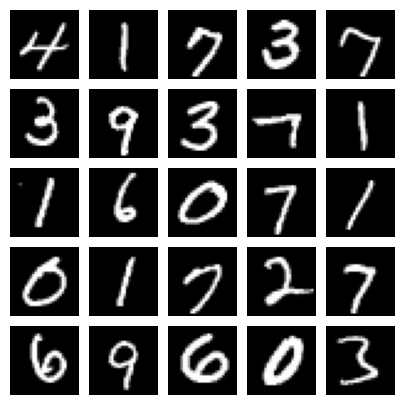

In [7]:
dataiter = iter(train_loader) #Get a batch of training data from the Dataloader
image = next(dataiter)
num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] # Extract grayscale images
fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)
#Plot each image in the grid
for ax, im in zip(grid, sample_images):
  ax.imshow(im, cmap='gray')# Display image in grayscale
  ax.axis('off')
plt.show()

In [11]:
class VAE (nn.Module):
  def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
    super(VAE, self).__init__()
    # encoder
    self.encoder = nn.Sequential(
        nn.Linear (input_dim, hidden_dim), #Fully connected layer
        nn.LeakyReLU(0.2), #Activation function
        nn.Linear (hidden_dim, latent_dim),
        nn.LeakyReLU(0.2)
        )
    #Layers to output mean and log variance for the latent space
    self.mean_layer = nn.Linear(latent_dim, 2)
    self.logvar_layer = nn.Linear(latent_dim, 2)
    #Decoder: Reconstructs the input from latent space
    self.decoder = nn.Sequential(
        nn.Linear(2, latent_dim),
        nn. LeakyReLU(0.2),
        nn. Linear (latent_dim, hidden_dim),
        nn. LeakyReLU(0.2),
        nn.Linear (hidden_dim, input_dim),
        nn.Sigmoid()#Output in range [0,1] to match original input
        )
  def encode(self, x):
    x = self.encoder(x) # Encode input to latent features
    mean, logvar = self.mean_layer(x), self.logvar_layer(x) #Predict mean and log variance of latent distribution
    return mean, logvar
  def reparameterization(self, mean, var):
    epsilon = torch.randn_like(var).to(device) # Sample epsilon from standard normal
    z = mean + var*epsilon #Reparameterization trick to sample z
    return z
  def decode(self, x):
    return self.decoder(x) # Decode latent vector back to original input space
  def forward(self, x):
    mean, logvar = self.encode(x) # Encode input into latent space
    z = self.reparameterization(mean, logvar)
    x_hat = self.decode(z)
    return x_hat, mean, logvar

In [23]:
def loss_function(x, x_hat, mean, log_var):
  reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction = 'sum') #Reconstruction loss (how close the output is to the input)
  KLD = - 0.5*torch.sum(1+ log_var - mean.pow(2) - log_var.exp()) #KL Divergence: regularizes the latent space to follow a standard normal distribution
  #Total loss reconstruction loss
  return reconstruction_loss + KLD

In [22]:
def train (model, optimizer, epochs, device, x_dim=784):
  model.train()
  for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
      x=x.view(batch_size, x_dim).to(device) # Flatten the image and move to device
      optimizer.zero_grad()
      #Forward pass through the VAE
      x_hat, mean, log_var = model(x)
      loss = loss_function(x, x_hat, mean, log_var) #Compute total loss (reconstruction+ KL divergence)
      overall_loss += loss.item()
      loss.backward() # Backpropagation
      optimizer.step() # Update model parameters
    #Print average loss per epoch
    print("\tEpoch", epoch + 1, "\tAverage Loss:", overall_loss/(batch_idx*batch_size))
  return overall_loss # Return total loss after training

In [25]:
# Instantiate the VAE model
model = VAE(device=device)  # Create an instance of the VAE class

# Define the optimizer
optimizer = Adam(model.parameters()) # Use Adam optimizer with model parameters

# Now you can train the model
train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss: 178.40652911101836
	Epoch 2 	Average Loss: 158.0576223230123
	Epoch 3 	Average Loss: 153.80179358175084
	Epoch 4 	Average Loss: 151.21372738744262
	Epoch 5 	Average Loss: 149.28120793770867
	Epoch 6 	Average Loss: 147.85795239787666
	Epoch 7 	Average Loss: 146.54993256990818
	Epoch 8 	Average Loss: 145.2946083152911
	Epoch 9 	Average Loss: 144.64998444673415
	Epoch 10 	Average Loss: 144.01165684669763
	Epoch 11 	Average Loss: 143.00088234622808
	Epoch 12 	Average Loss: 142.36261916018887
	Epoch 13 	Average Loss: 142.00514320742906
	Epoch 14 	Average Loss: 141.65864665392843
	Epoch 15 	Average Loss: 141.29648455433536
	Epoch 16 	Average Loss: 140.44312744548205
	Epoch 17 	Average Loss: 140.36861277585038
	Epoch 18 	Average Loss: 140.0563539818969
	Epoch 19 	Average Loss: 139.8802622371922
	Epoch 20 	Average Loss: 139.38709535423624
	Epoch 21 	Average Loss: 139.0628314606375
	Epoch 22 	Average Loss: 138.70866894042155
	Epoch 23 	Average Loss: 138.524087981923
	Epo

8049309.408203125

In [26]:
def generate_digit(mean,var):
  #create a latent vector z from the provided mean and variance
  z_sample=torch.tensor([[mean,var]], dtype=torch.float).to(device)
  x_decoded=model.decode(z_sample)
  digit=x_decoded.cpu().detach().reshape(28,28) # Detach the tensor from the computation graph before converting to NumPy

  #plot the generated digit
  plt.title(f'[{mean},{var}]')
  plt.imshow(digit, cmap='gray')
  plt.axis('off')
  plt.show()

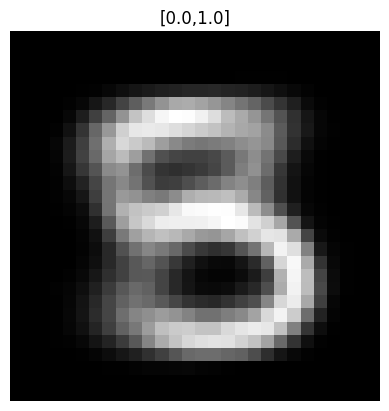

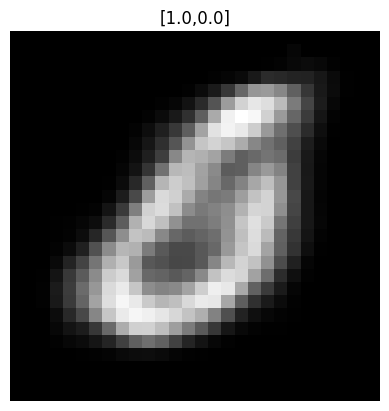

(None, None)

In [27]:
#img1:mean,var1/img2:mean1,var0
generate_digit(0.0,1.0),generate_digit(1.0,0.0)

In [28]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
  figure = np.zeros((digit_size * n, digit_size * n))  # Use np.zeros instead of np.zeroes

  grid_x = np.linspace(-scale, scale, n)
  grid_y = np.linspace(-scale, scale, n)[::-1]

  for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
      z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
      x_decoded = model.decode(z_sample)
      digit = x_decoded[0].cpu().detach().reshape(digit_size, digit_size)
      figure[i * digit_size:(i + 1) * digit_size, j * digit_size:(j + 1) * digit_size] = digit

  plt.figure(figsize=(figsize, figsize))  # Pass figsize as a keyword argument
  plt.title('VAE Latent Space Visualization')
  start_range = digit_size // 2
  end_range = n * digit_size + start_range
  pixel_range = np.arange(start_range, end_range, digit_size)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel("mean, z[0]")
  plt.ylabel("var, z[1]")
  plt.imshow(figure, cmap='Greys_r')
  plt.show()

<ipython-input-28-094842101053>:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  figure[i * digit_size:(i + 1) * digit_size, j * digit_size:(j + 1) * digit_size] = digit


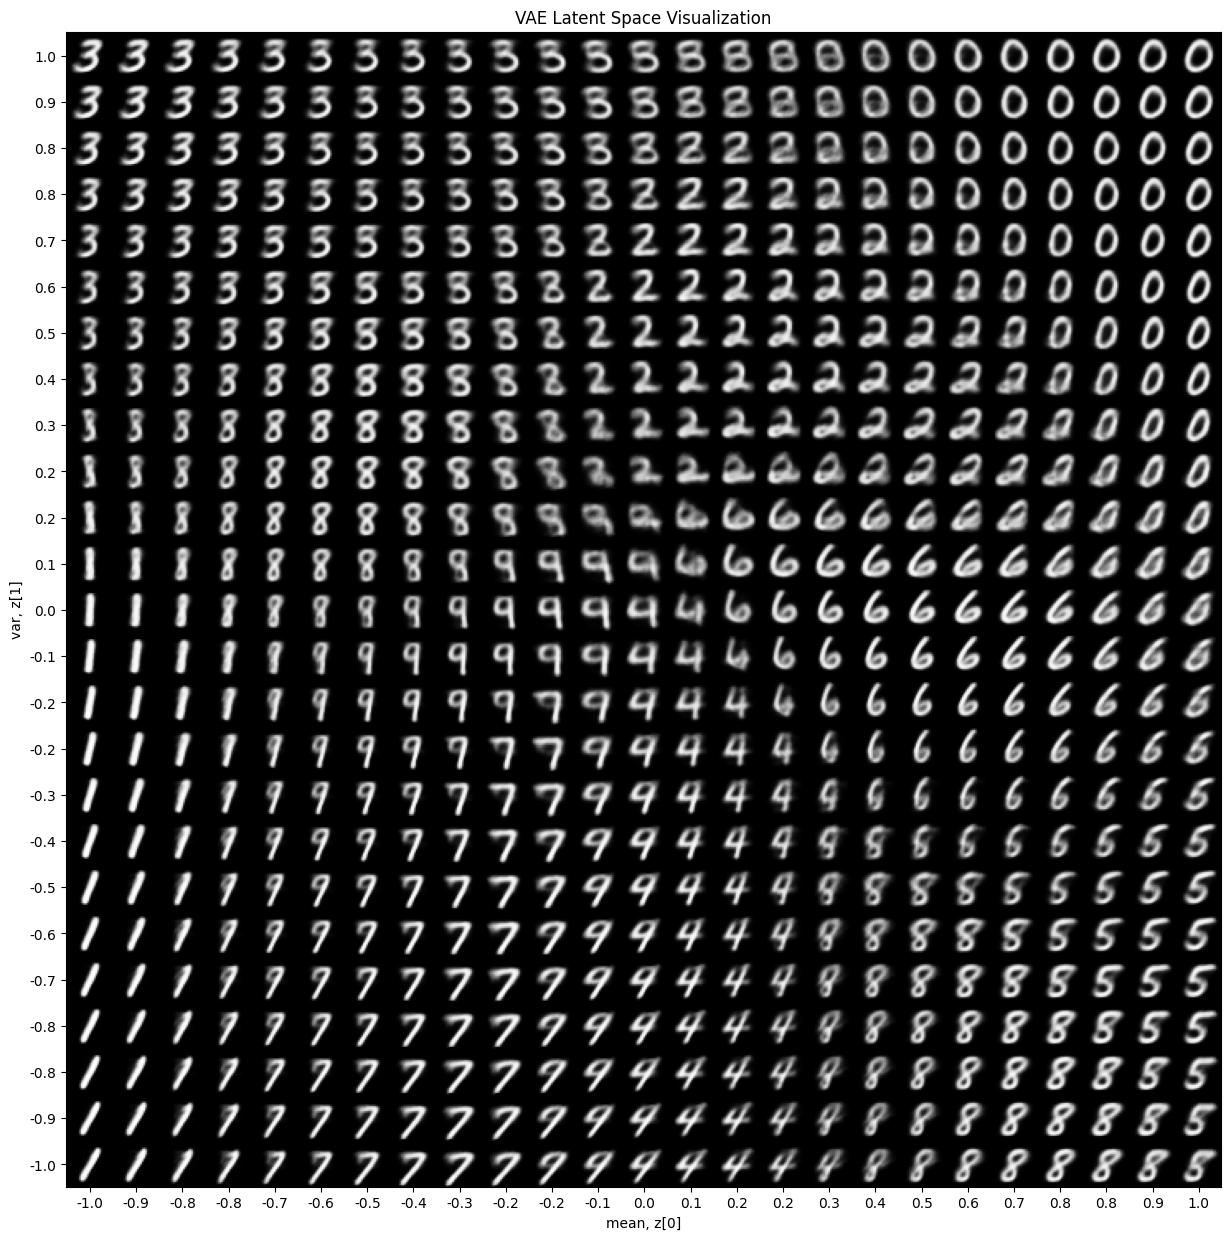

In [29]:
plot_latent_space(model,scale=1.0)